In [1]:
import sys
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import scipy.sparse
from scipy.sparse import hstack
import sklearn.metrics

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression, Lasso, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import recall_score, precision_score,  roc_auc_score, confusion_matrix
from sklearn.ensemble import VotingClassifier

import nltk
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('notebook') 
sns.set_style('ticks')
plt.rcParams['figure.figsize'] = (7, 5)
%matplotlib inline

my_cmap = plt.cm.GnBu

In [2]:
seed = 5
np.random.seed(seed)

In [3]:
%run "tqdm.ipynb"
%run "functions.ipynb"

# Loading data

In [4]:
dataPath = '../data/cgu/'
dataName = 'CGU_data_class_touse.xlsx'
data = pd.read_excel(dataPath+dataName, encoding='utf-8')

# deleting irregularities with no description
data = data[data['descricao_sumaria'].notnull()] 

# Data pre-processing

In [5]:
#selecting only columns of interest
data = data[['descricao_sumaria', 'Class_10', 'Class_2', 'Orgao_Sup_cod', 'Tipo_constatacao', 'Id_Irreg', 'Municipio', 
             'UF', 'Ano_Sorteio', 'Ind_class', 'Id_Mun_Sort']]

#num to str on the class column
#data['Class_10'] = data['Class_10'].apply(str) 
#data['Class_2'] = data['Class_2'].apply(str) 

#Creating binary features for 'Orgao_Sup' and 'Tipo_constatacao'
min_dum = pd.get_dummies(data['Orgao_Sup_cod'], drop_first=True)
data = data.join(min_dum)
list_min = list(np.sum(min_dum).index)

type_dum = pd.get_dummies(data['Tipo_constatacao'], drop_first=True)
data = data.join(type_dum)
list_type = list(np.sum(type_dum).index)

# Text pre-processing

In [6]:
#list of portuguese stopwords
stopwords = nltk.corpus.stopwords.words('portuguese')
extra = ['nº', 'N.º', 'r'] # Should we include these extra stopwords? - *r comes from R $ *
[stopwords.append(word) for word in extra];  
    
#tokens
data['tokens'] = data['descricao_sumaria'].apply(tok_text) 

#bigrams
bigrams = [list(nltk.bigrams(text)) for text in data['tokens']]
data['bigrams'] = bigrams

#tokens and bigrams
features = data['descricao_sumaria'].apply(tok_text) + [list(nltk.bigrams(text)) for text in data['tokens']]
data['features'] = features

#counting number of tokens
data['length'] = data['tokens'].apply(len)

data.head()

,descricao_sumaria,Class_10,Class_2,Orgao_Sup_cod,Tipo_constatacao,Id_Irreg,Municipio,UF,Ano_Sorteio,Ind_class,...,TEC,TRAB,TRANSP,TUR,Falha Grave,Falha Média,tokens,bigrams,features,length
0,Contrapartida municipal na Assistência Farmacê...,NaN,NaN,SAU,Falha Formal,Afogados da Ingazeira_040_1,Afogados da Ingazeira,PE,2015,0,...,0,0,0,0,0,0,"[contrapartida, municip, assistência, farmacêu...","[(contrapartida, municip), (municip, assistênc...","[contrapartida, municip, assistência, farmacêu...",16
1,Falta de atestado de conferência e recebimento...,NaN,NaN,SAU,Falha Formal,Afogados da Ingazeira_040_2,Afogados da Ingazeira,PE,2015,0,...,0,0,0,0,0,0,"[falta, atestado, conferência, recebimento, me...","[(falta, atestado), (atestado, conferência), (...","[falta, atestado, conferência, recebimento, me...",11
2,Ineficiência do controle de estoque de medicam...,NaN,NaN,SAU,Falha Média,Afogados da Ingazeira_040_3,Afogados da Ingazeira,PE,2015,0,...,0,0,0,0,0,1,"[ineficiência, control, estoqu, medicamento, u...","[(ineficiência, control), (control, estoqu), (...","[ineficiência, control, estoqu, medicamento, u...",7
3,Ineficiência do controle de estoque de medicam...,NaN,NaN,SAU,Falha Média,Afogados da Ingazeira_040_4,Afogados da Ingazeira,PE,2015,0,...,0,0,0,0,0,1,"[ineficiência, control, estoqu, medicamento, a...","[(ineficiência, control), (control, estoqu), (...","[ineficiência, control, estoqu, medicamento, a...",9
4,Previsões editalícias restritivas ao caráter c...,NaN,NaN,SAU,Falha Média,Afogados da Ingazeira_040_5,Afogados da Ingazeira,PE,2015,0,...,0,0,0,0,0,1,"[previsõ, editalícia, restritiva, caráter, com...","[(previsõ, editalícia), (editalícia, restritiv...","[previsõ, editalícia, restritiva, caráter, com...",9


# Splitting *supervised* and *unsupervised* samples

In [7]:
supervised = data[data['Ind_class']==1].reset_index(drop=True)
unsupervised = data[data['Ind_class']==0].reset_index(drop=True)

# Supervised learning task

## Split train-test (stratified)

In [8]:
level = list(np.unique(supervised['Tipo_constatacao'].values))
classes = list(np.unique(supervised['Class_10'].values))

In [9]:
samples = []
for lev in level:
    for clas in classes:
        x = supervised[(supervised['Class_10'] == clas) & (supervised['Tipo_constatacao'] == lev)].sample(frac=0.7, random_state=seed)
        samples.append(x)
train = pd.concat(samples)

test = supervised[supervised.index.isin(train.index)==False].copy()

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

y_train = train['Class_10'].values
y_test = test['Class_10'].values

y_train_2 = train['Class_2'].values
y_test_2 = test['Class_2'].values

## Frequency of text features

### Words

In [10]:
freqTokens_train = word_freq(train, 'tokens')
print('Train dataset: ',freqTokens_train.most_common()[:20])

Train dataset:  [('ausência', 507), ('programa', 459), ('recurso', 445), ('saúd', 313), ('família', 292), ('municip', 249), ('falta', 228), ('despesa', 217), ('escolar', 210), ('control', 179), ('pagamento', 174), ('processo', 168), ('bolsa', 167), ('licitatório', 163), ('beneficiário', 163), ('conselho', 160), ('execução', 158), ('serviço', 151), ('convênio', 137), ('contrato', 134)]


In [11]:
tokens = pd.Series(dict(freqTokens_train))
tokens = tokens.sort_values(ascending=False)
tokens.describe().round()

count    2672.0
mean        9.0
std        26.0
min         1.0
25%         1.0
50%         2.0
75%         6.0
max       507.0
dtype: float64

### Bigrams

In [12]:
freqBigrams_train = word_freq(train, 'bigrams')
print('Entire dataset: ',freqBigrams_train.most_common()[:20])

Entire dataset:  [(('bolsa', 'família'), 152), (('programa', 'bolsa'), 122), (('processo', 'licitatório'), 115), (('municip', 'saúd'), 87), (('contrato', 'repass'), 70), (('saúd', 'família'), 69), (('beneficiário', 'programa'), 65), (('conselho', 'municip'), 65), (('renda', 'per'), 64), (('per', 'capita'), 63), (('atenção', 'básica'), 55), (('superior', 'estabelecida'), 54), (('ausência', 'comprovação'), 52), (('assistência', 'social'), 51), (('merenda', 'escolar'), 50), (('capita', 'superior'), 50), (('alimentação', 'escolar'), 46), (('estabelecida', 'legislação'), 46), (('partido', 'político'), 45), (('recurso', 'federai'), 45)]


In [13]:
bigrams = pd.Series(dict(freqBigrams_train))
bigrams = bigrams.sort_values(ascending=False)
bigrams.describe().round()

count    10474.0
mean         2.0
std          4.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max        152.0
dtype: float64

### Words and Bigrams

In [14]:
freqFeatures_train = word_freq(train, 'features')
print('Entire dataset: ',freqFeatures_train.most_common()[:20])

Entire dataset:  [('ausência', 507), ('programa', 459), ('recurso', 445), ('saúd', 313), ('família', 292), ('municip', 249), ('falta', 228), ('despesa', 217), ('escolar', 210), ('control', 179), ('pagamento', 174), ('processo', 168), ('bolsa', 167), ('licitatório', 163), ('beneficiário', 163), ('conselho', 160), ('execução', 158), (('bolsa', 'família'), 152), ('serviço', 151), ('convênio', 137)]


In [15]:
features = pd.Series(dict(freqFeatures_train))
features = features.sort_values(ascending=False)
features.describe().round()

count    13146.0
mean         3.0
std         13.0
min          1.0
25%          1.0
50%          1.0
75%          2.0
max        507.0
dtype: float64

### Restricting the list of features

From the above information, we can see that 75% of the available features (words or bigrams) occur less than two times in the training set. We are going to restrict our features space to those that appear at least two times, to avoid overfitting.

In [16]:
features = features[features >= 2]
len(features)

3908

## 10-classes classification

The problem of imbalanced classes:

When we encounter such problems, we are bound to have difficulties solving them with standard algorithms. Conventional algorithms are often biased towards the majority class, not taking the data distribution into consideration. In the worst case, minority classes are treated as outliers and ignored. For some cases, such as fraud detection or cancer prediction, we would need to carefully configure our model or artificially balance the dataset, for example by undersampling or oversampling (https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis) each class.

In our case, classes associated to corruption are not the majority, and altough we want want to achieve a good accuracy, it is not a big problem if the algorithm does recognize some irregularities as corruption. The opposite case is worse: when a irregularity is not associated to overinvoicing, procurement problems or resources diversion and the algorithm misclassifies it.

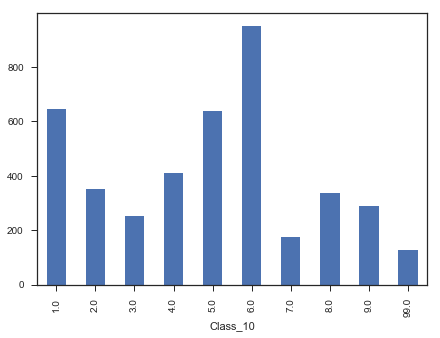

In [17]:
supervised.groupby('Class_10').descricao_sumaria.count().plot.bar(ylim=0)
plt.show()

### Cross-validation for tuning hyper-parameters

#### Naive Bayes

For the Naive Bayes, we rank features to be included according to their performance on univariate models, measured by log-loss.

Then we perform cross validation, evaluating the model performance at each 10 new features included.

In [18]:
losses=[]
for feature in features.index:
    losses.append(training_error(feature, train, y_train, 'features'))

ranked = pd.Series(losses, index=features.index)
ranked = ranked.sort_values()
rank_features = list(ranked.index) 
print(rank_features)

['conselho', 'licitatório', 'beneficiário', 'recurso', 'obra', 'despesa', 'renda', 'processo', ('processo', 'licitatório'), 'per', 'família', 'programa', ('renda', 'per'), 'capita', ('per', 'capita'), 'bolsa', ('bolsa', 'família'), 'superior', 'licitação', ('superior', 'estabelecida'), 'municip', ('capita', 'superior'), 'estabelecida', ('conselho', 'municip'), 'atuação', ('estabelecida', 'legislação'), 'profissionai', ('programa', 'bolsa'), 'notificação', 'documento', 'pagamento', 'control', 'preço', 'aluno', 'social', 'equip', 'saúd', 'legislação', 'fiscai', 'medicamento', 'conta', 'nota', ('legislação', 'programa'), 'identificação', 'capacitação', ('beneficiário', 'programa'), ('municip', 'saúd'), 'escolar', 'divergência', ('nota', 'fiscai'), ('saúd', 'família'), 'censo', 'aquisição', 'contratação', 'documentação', ('prestação', 'conta'), 'execução', 'partido', 'político', ('partido', 'político'), 'convit', 'edit', 'entidad', 'estoqu', 'indício', 'prestação', 'acompanhamento', 'carga

In [19]:
"""
n_features, cv_errors_nb, test_errors_nb = NB_selection(train, test, rank_features, 'features', 
                                                        'Class_10', list_min, list_type)
plot_error(n_features, cv_errors_nb, test_errors_nb, 'Naive Bayes Classifier')
                                                        """

"\nn_features, cv_errors_nb, test_errors_nb = NB_selection(train, test, rank_features, 'features', \n                                                        'Class_10', list_min, list_type)\nplot_error(n_features, cv_errors_nb, test_errors_nb, 'Naive Bayes Classifier')\n                                                        "

In [20]:
model_NB = Pipeline([('vect', CountVectorizer(analyzer = 'word', stop_words = stopwords, ngram_range=(1, 1))),
                     ('tfidf', TfidfTransformer(use_idf = False, norm="l2")),
                     ('clf', BernoulliNB(alpha = 0.01))])

_ = model_NB.fit(train['descricao_sumaria'], train['Class_10'])

y_pred_nb = model_NB.predict(test['descricao_sumaria'])
acc_nb = sklearn.metrics.accuracy_score(test['Class_10'], y_pred_nb)
scores_nb = cross_val_score(model_NB, train['descricao_sumaria'], train['Class_10'], cv=10)

print('CV scores: {}'.format(scores_nb))
print('Average CVScore: {:0.3f} +/- {:0.3f}'.format(scores_nb.mean(), scores_nb.std()))
print('Accuracy on the test set: {}'.format(acc_nb))

CV scores: [ 0.71043771  0.75510204  0.74829932  0.73809524  0.74829932  0.72068966
  0.7266436   0.74305556  0.71875     0.70383275]
Average CVScore: 0.731 +/- 0.017
Accuracy on the test set: 0.7450039968025579


So our hyper-parameters for Naive Bayes are alpha = 0.01 and 1950 features.

#### Multinomial Logistic Regression

In [21]:
model_LR = Pipeline([('vect', CountVectorizer(analyzer = 'word', stop_words = stopwords, ngram_range=(1, 1))),
                     ('tfidf', TfidfTransformer(use_idf = True, norm="l2")),
                     ('clf-lr', LogisticRegression(penalty = 'l2', C=5, class_weight="balanced", 
                                                   random_state=seed))])

scores_lr = cross_val_score(model_LR, train['descricao_sumaria'], train['Class_10'], cv=10)
_ = model_LR.fit(train['descricao_sumaria'], train['Class_10'])

y_pred_lr = model_LR.predict(test['descricao_sumaria'])
acc_lr = sklearn.metrics.accuracy_score(test['Class_10'], y_pred_lr)

print('CV scores: {}'.format(scores_lr))
print('Average CVScore: {:0.3f} +/- {:0.3f}'.format(scores_lr.mean(), scores_lr.std()))
print('Accuracy on the test set: {}'.format(acc_lr))

CV scores: [ 0.74074074  0.7755102   0.78571429  0.79591837  0.79591837  0.78965517
  0.80968858  0.79513889  0.78819444  0.75261324]
Average CVScore: 0.783 +/- 0.020
Accuracy on the test set: 0.8081534772182254


In [22]:
parameters_lr = {'vect__ngram_range': [(1, 1), (1, 2)],
                  'tfidf__use_idf': (True, False),
                  'clf-lr__penalty': ('l2', 'l1'),
                  'clf-lr__C': (2, 5)}
gs_lr = GridSearchCV(model_LR, parameters_lr, n_jobs=-1)
gs_lr = gs_lr.fit(train['descricao_sumaria'], train['Class_10'])
gs_lr.best_score_
gs_lr.best_params_

{'clf-lr__C': 5,
 'clf-lr__penalty': 'l2',
 'tfidf__use_idf': True,
 'vect__ngram_range': (1, 1)}

#### SVM

In [23]:
model_svm = Pipeline([('vect', CountVectorizer(analyzer = 'word', stop_words = stopwords, ngram_range=(1, 2))),
                      ('tfidf', TfidfTransformer(use_idf = False, norm="l2")),
                      ('clf-svm', SGDClassifier(loss='hinge', penalty='l2', alpha=0.001, max_iter=500, 
                                                random_state=seed))])

_ = model_svm.fit(train['descricao_sumaria'], train['Class_10'])

y_pred_svm = model_svm.predict(test['descricao_sumaria'])
acc_svm = sklearn.metrics.accuracy_score(test['Class_10'], y_pred_svm)
scores_svm = cross_val_score(model_svm, train['descricao_sumaria'], train['Class_10'], cv=10)

print('CV scores: {}'.format(scores_svm))
print('Average CVScore: {:0.3f} +/- {:0.3f}'.format(scores_svm.mean(), scores_svm.std()))
print('Accuracy on the test set: {}'.format(acc_svm))

CV scores: [ 0.74747475  0.75510204  0.77891156  0.78571429  0.77210884  0.78275862
  0.78546713  0.8125      0.78472222  0.73867596]
Average CVScore: 0.774 +/- 0.021
Accuracy on the test set: 0.7993605115907274


In [24]:
parameters_svm = {'vect__ngram_range': [(1, 1), (1, 2)],
                  'tfidf__use_idf': (True, False),
                  'clf-svm__penalty': ('l2', 'elasticnet'),
                  'clf-svm__alpha': (0.01, 0.001)}
gs_svm = GridSearchCV(model_svm, parameters_svm, n_jobs=-1)
gs_svm = gs_svm.fit(train['descricao_sumaria'], train['Class_10'])
gs_svm.best_score_
gs_svm.best_params_

{'clf-svm__alpha': 0.001,
 'clf-svm__penalty': 'l2',
 'tfidf__use_idf': True,
 'vect__ngram_range': (1, 2)}

In [25]:
model_svc = Pipeline([('vect', CountVectorizer(analyzer = 'word', stop_words = stopwords, ngram_range=(1, 2))),
                      ('tfidf', TfidfTransformer(use_idf = False, norm="l2")),
                      ('clf-svc', SVC(kernel="linear", C=1, random_state=seed))])

_ = model_svc.fit(train['descricao_sumaria'], train['Class_10'])

y_pred_svc = model_svc.predict(test['descricao_sumaria'])
acc_svc = sklearn.metrics.accuracy_score(test['Class_10'], y_pred_svc)
scores_svc = cross_val_score(model_svc, train['descricao_sumaria'], train['Class_10'], cv=10)

print('CV scores: {}'.format(scores_svc))
print('Average CVScore: {:0.3f} +/- {:0.3f}'.format(scores_svc.mean(), scores_svc.std()))
print('Accuracy on the test set: {}'.format(acc_svc))

CV scores: [ 0.72727273  0.76870748  0.7755102   0.76870748  0.78571429  0.74827586
  0.79584775  0.79513889  0.77777778  0.74216028]
Average CVScore: 0.769 +/- 0.022
Accuracy on the test set: 0.7961630695443646


#### Random Forest

In [26]:
model_RF = Pipeline([('vect', CountVectorizer(analyzer = 'word', stop_words = stopwords, ngram_range=(1, 1))),
                      ('tfidf', TfidfTransformer(use_idf = True)),
                      ('clf-rf', RandomForestClassifier(n_estimators=1000, criterion='gini',
                                                    random_state=seed))])

scores_rf = cross_val_score(model_LR, train['descricao_sumaria'], train['Class_10'], cv=10)
_ = model_RF.fit(train['descricao_sumaria'], train['Class_10'])

y_pred_rf = model_RF.predict(test['descricao_sumaria'])
acc_rf = sklearn.metrics.accuracy_score(test['Class_10'], y_pred_rf)

print('CV scores: {}'.format(scores_rf))
print('Average CVScore: {:0.3f} +/- {:0.3f}'.format(scores_rf.mean(), scores_rf.std()))
print('Accuracy on the test set: {}'.format(acc_rf))

CV scores: [ 0.74074074  0.7755102   0.78571429  0.79591837  0.79591837  0.78965517
  0.80968858  0.79513889  0.78819444  0.75261324]
Average CVScore: 0.783 +/- 0.020
Accuracy on the test set: 0.7705835331734612


In [27]:
parameters_rf = {'vect__ngram_range': [(1, 1), (1, 2)],
                  'tfidf__use_idf': (True, False),
                  'clf-rf__criterion': ('gini', 'entropy')}
gs_rf = GridSearchCV(model_RF, parameters_rf, n_jobs=-1)
gs_rf = gs_rf.fit(train['descricao_sumaria'], train['Class_10'])
gs_rf.best_score_
gs_rf.best_params_

{'clf-rf__criterion': 'gini',
 'tfidf__use_idf': False,
 'vect__ngram_range': (1, 1)}

### Model Selection

In [28]:
train_min_feat = train[list_min+list_type].values
train_word_feat = design_matrix(rank_features, train['features'])
X_train = scipy.sparse.hstack((train_min_feat, train_word_feat))

test_min_feat = test[list_min+list_type].values
test_word_feat = design_matrix(rank_features, test['features'])
X_test = scipy.sparse.hstack((test_min_feat, test_word_feat))

In [29]:
NB_10 = BernoulliNB(alpha = 0.01)
LR_10 = LogisticRegression(penalty = 'l2', C=5, class_weight="balanced", random_state=seed)
SVC_10 = SVC(kernel="linear", C=1, random_state=seed, probability=True)
RF_10 = RandomForestClassifier(n_estimators=1000, criterion='gini',random_state=seed)
voting = VotingClassifier(estimators=[('lr', LR_10), ('nb', NB_10), ('svc', SVC_10), ('rf', RF_10)], voting='soft', 
                          weights=[1,1,1,1], flatten_transform=True)
models = [NB_10, LR_10, SVC_10, RF_10, voting]

0.744193314871
0.777100572034
0.756851195332
0.750001442483
0.780182430746


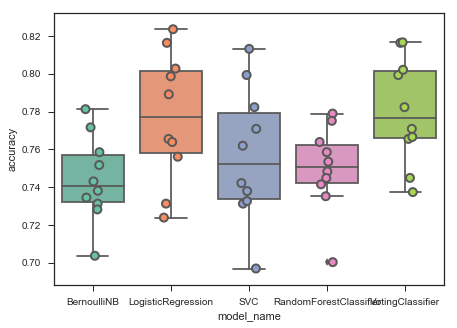

In [30]:
CV = 10
cv_df_10 = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=CV)
    print(np.mean(accuracies))
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
        cv_df_10 = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

sns.boxplot(x='model_name', y='accuracy', data=cv_df_10, palette="Set2", saturation=0.7)
sns.stripplot(x='model_name', y='accuracy', data=cv_df_10, size=8, jitter=True, edgecolor="gray", linewidth=2,palette="Set2")
plt.show()

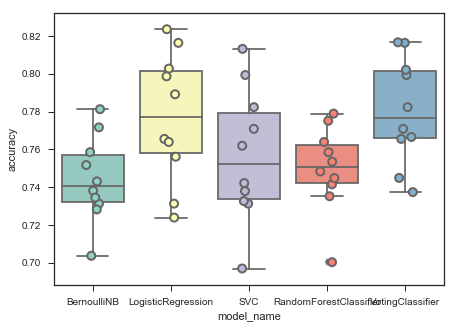

In [31]:
sns.boxplot(x='model_name', y='accuracy', data=cv_df_10, palette="Set3")
sns.stripplot(x='model_name', y='accuracy', data=cv_df_10, size=8, jitter=True, edgecolor="gray", linewidth=2, palette="Set3")
plt.show()

In [32]:
NB_10_model = NB_10.fit(X_train, y_train)
y_pred_NB_10 = NB_10_model.predict(X_test)
scores_NB_10 = cross_val_score(NB_10, X_train, y_train, cv=10)
acc_NB_10 = sklearn.metrics.accuracy_score(y_test, y_pred_NB_10)

print('CV scores: {}'.format(scores_NB_10))
print('Average CVScore: {:0.3f} +/- {:0.3f}'.format(scores_NB_10.mean(), scores_NB_10.std()))
print('Accuracy on the test set: {}'.format(acc_NB_10))

CV scores: [ 0.7037037   0.73129252  0.7585034   0.75170068  0.73809524  0.73448276
  0.7716263   0.78125     0.74305556  0.728223  ]
Average CVScore: 0.744 +/- 0.021
Accuracy on the test set: 0.7777777777777778


In [33]:
LR_10_model = LR_10.fit(X_train, y_train)
y_pred_LR_10 = LR_10_model.predict(X_test)
scores_LR_10 = cross_val_score(LR_10, X_train, y_train, cv=10)
acc_LR_10 = sklearn.metrics.accuracy_score(y_test, y_pred_LR_10)

print('CV scores: {}'.format(scores_LR_10))
print('Average CVScore: {:0.3f} +/- {:0.3f}'.format(scores_LR_10.mean(), scores_LR_10.std()))
print('Accuracy on the test set: {}'.format(acc_LR_10))

CV scores: [ 0.72390572  0.73129252  0.78911565  0.81632653  0.80272109  0.76551724
  0.82352941  0.79861111  0.76388889  0.75609756]
Average CVScore: 0.777 +/- 0.033
Accuracy on the test set: 0.7945643485211831


In [34]:
SVC_10_model = SVC_10.fit(X_train, y_train)
y_pred_SVC_10 = SVC_10_model.predict(X_test)
scores_SVC_10 = cross_val_score(SVC_10, X_train, y_train, cv=10)
acc_SVC_10 = sklearn.metrics.accuracy_score(y_test, y_pred_SVC_10)

print('CV scores: {}'.format(scores_SVC_10))
print('Average CVScore: {:0.3f} +/- {:0.3f}'.format(scores_SVC_10.mean(), scores_SVC_10.std()))
print('Accuracy on the test set: {}'.format(acc_SVC_10))

CV scores: [ 0.6969697   0.73129252  0.78231293  0.79931973  0.76190476  0.73793103
  0.81314879  0.77083333  0.73263889  0.74216028]
Average CVScore: 0.757 +/- 0.034
Accuracy on the test set: 0.7785771382893685


In [35]:
RF_10_model = RF_10.fit(X_train, y_train)
y_pred_RF_10 = RF_10_model.predict(X_test)
scores_RF_10 = cross_val_score(RF_10, X_train, y_train, cv=10)
acc_RF_10 = sklearn.metrics.accuracy_score(y_test, y_pred_RF_10)

print('CV scores: {}'.format(scores_RF_10))
print('Average CVScore: {:0.3f} +/- {:0.3f}'.format(scores_RF_10.mean(), scores_RF_10.std()))
print('Accuracy on the test set: {}'.format(acc_RF_10))

CV scores: [ 0.7003367   0.7414966   0.7585034   0.77891156  0.74829932  0.74482759
  0.77508651  0.76388889  0.75347222  0.73519164]
Average CVScore: 0.750 +/- 0.021
Accuracy on the test set: 0.7817745803357314


In [36]:
voting = VotingClassifier(estimators=[('lr', LR_10), ('nb', NB_10), ('svc', SVC_10), ('rf', RF_10)], voting='soft', 
                          weights=[1,1,1,1], flatten_transform=True)
voting_model = voting.fit(X_train, y_train)
y_pred_voting = voting.predict(X_test)
scores_voting = cross_val_score(voting, X_train, y_train, cv=10)
acc_voting = sklearn.metrics.accuracy_score(y_test, y_pred_voting)

print('CV scores: {}'.format(scores_voting))
print('Average CVScore: {:0.3f} +/- {:0.3f}'.format(scores_voting.mean(), scores_voting.std()))
print('Accuracy on the test set: {}'.format(acc_voting))

CV scores: [ 0.73737374  0.74489796  0.79931973  0.81632653  0.78231293  0.76551724
  0.816609    0.80208333  0.77083333  0.76655052]
Average CVScore: 0.780 +/- 0.027
Accuracy on the test set: 0.8033573141486811


**Performance metrics:**

In [37]:
print(metrics.classification_report(y_test, y_pred_voting,  target_names=['FL', 'DR+SF', 'FD', 'IM', 'MM', 'IF', 'OB', 'RH', 'DOC', 'INFO+RE' ]))

             precision    recall  f1-score   support

         FL       0.87      0.84      0.85       194
      DR+SF       0.66      0.72      0.69       104
         FD       0.89      0.88      0.89        76
         IM       0.91      0.86      0.88       122
         MM       0.76      0.69      0.72       192
         IF       0.81      0.87      0.84       285
         OB       0.67      0.83      0.74        52
         RH       0.83      0.79      0.81       101
        DOC       0.76      0.76      0.76        86
    INFO+RE       0.82      0.69      0.75        39

avg / total       0.81      0.80      0.80      1251



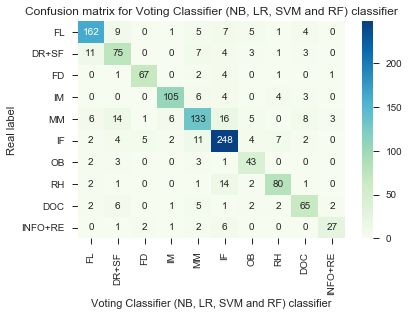

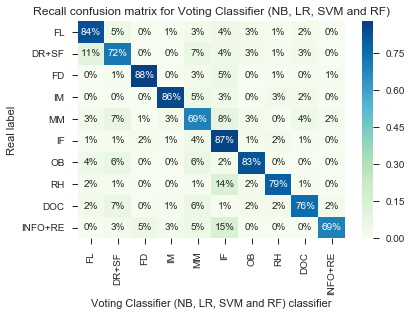

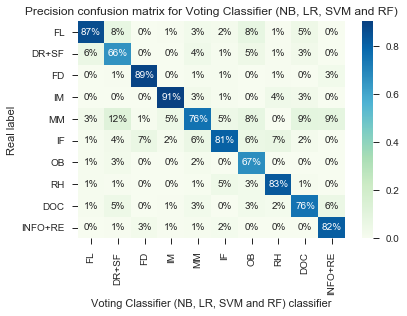

In [38]:
plot_confusion(y_test, y_pred_voting, 10, 'Voting Classifier (NB, LR, SVM and RF)', my_cmap)

## 2-classes classification

### Cross-validation for tuning hyperparameters

#### Naive Bayes

In [39]:
model_NB = Pipeline([('vect', CountVectorizer(analyzer = 'word', stop_words = stopwords, ngram_range=(1, 1))),
                     ('tfidf', TfidfTransformer(use_idf = True, norm="l2")),
                     ('clf-nb', BernoulliNB(alpha = 1))])

_ = model_NB.fit(train['descricao_sumaria'], train['Class_2'])

y_pred_nb = model_NB.predict(test['descricao_sumaria'])
acc_nb = sklearn.metrics.accuracy_score(test['Class_2'], y_pred_nb)
scores_nb = cross_val_score(model_NB, train['descricao_sumaria'], train['Class_2'], cv=10)

print('CV scores: {}'.format(scores_nb))
print('Average CVScore: {:0.3f} +/- {:0.3f}'.format(scores_nb.mean(), scores_nb.std()))
print('Accuracy on the test set: {}'.format(acc_nb))

CV scores: [ 0.93493151  0.90753425  0.89041096  0.92123288  0.90753425  0.95547945
  0.97250859  0.91408935  0.8419244   0.8       ]
Average CVScore: 0.905 +/- 0.049
Accuracy on the test set: 0.9136690647482014


In [40]:
parameters_nb = {'vect__ngram_range': [(1, 1), (1, 2)],
                  'tfidf__use_idf': (True, False),
                  'clf-nb__alpha': (0.1, 1)}
gs_nb = GridSearchCV(model_NB, parameters_nb, n_jobs=-1)
gs_nb = gs_nb.fit(train['descricao_sumaria'], train['Class_2'])
gs_nb.best_score_
gs_nb.best_params_

{'clf-nb__alpha': 0.1, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}

#### Multinomial Logistic Regression

In [41]:
model_LR = Pipeline([('vect', CountVectorizer(analyzer = 'word', stop_words = stopwords, ngram_range=(1, 1))),
                     ('tfidf', TfidfTransformer(use_idf = True, norm="l2")),
                     ('clf-lr', LogisticRegression(penalty = 'l2', C=5, class_weight="balanced", 
                                                   random_state=seed))])

scores_lr = cross_val_score(model_LR, train['descricao_sumaria'], train['Class_2'], cv=10)
_ = model_LR.fit(train['descricao_sumaria'], train['Class_2'])

y_pred_lr = model_LR.predict(test['descricao_sumaria'])
acc_lr = sklearn.metrics.accuracy_score(test['Class_2'], y_pred_lr)

print('CV scores: {}'.format(scores_lr))
print('Average CVScore: {:0.3f} +/- {:0.3f}'.format(scores_lr.mean(), scores_lr.std()))
print('Accuracy on the test set: {}'.format(acc_lr))

CV scores: [ 0.93493151  0.90410959  0.93493151  0.93150685  0.86643836  0.95547945
  0.96219931  0.9347079   0.88316151  0.84827586]
Average CVScore: 0.916 +/- 0.036
Accuracy on the test set: 0.9320543565147882


In [42]:
parameters_lr = {'vect__ngram_range': [(1, 1), (1, 2)],
                  'tfidf__use_idf': (True, False),
                  'clf-lr__penalty': ('l2', 'l1'),
                  'clf-lr__C': (2, 5)}
gs_lr = GridSearchCV(model_LR, parameters_lr, n_jobs=-1)
gs_lr = gs_lr.fit(train['descricao_sumaria'], train['Class_2'])
gs_lr.best_score_
gs_lr.best_params_

{'clf-lr__C': 5,
 'clf-lr__penalty': 'l2',
 'tfidf__use_idf': True,
 'vect__ngram_range': (1, 2)}

#### SVM

In [43]:
model_svm = Pipeline([('vect', CountVectorizer(analyzer = 'word', stop_words = stopwords, ngram_range=(1, 1))),
                      ('tfidf', TfidfTransformer(use_idf = True, norm="l2")),
                      ('clf-svm', SGDClassifier(loss='hinge', penalty='l2', alpha=0.001, max_iter=500, 
                                                random_state=seed))])

_ = model_svm.fit(train['descricao_sumaria'], train['Class_2'])

y_pred_svm = model_svm.predict(test['descricao_sumaria'])
acc_svm = sklearn.metrics.accuracy_score(test['Class_2'], y_pred_svm)
scores_svm = cross_val_score(model_svm, train['descricao_sumaria'], train['Class_2'], cv=10)

print('CV scores: {}'.format(scores_svm))
print('Average CVScore: {:0.3f} +/- {:0.3f}'.format(scores_svm.mean(), scores_svm.std()))
print('Accuracy on the test set: {}'.format(acc_svm))

CV scores: [ 0.92123288  0.93150685  0.8630137   0.91780822  0.91438356  0.95547945
  0.95189003  0.91408935  0.86941581  0.84827586]
Average CVScore: 0.909 +/- 0.035
Accuracy on the test set: 0.9104716227018386


In [44]:
parameters_svm = {'vect__ngram_range': [(1, 1), (1, 2)],
                  'tfidf__use_idf': (True, False),
                  'clf-svm__penalty': ('l2', 'elasticnet'),
                  'clf-svm__alpha': (0.0001, 0.001)}
gs_svm = GridSearchCV(model_svm, parameters_svm, n_jobs=-1)
gs_svm = gs_svm.fit(train['descricao_sumaria'], train['Class_2'])
gs_svm.best_score_
gs_svm.best_params_

{'clf-svm__alpha': 0.0001,
 'clf-svm__penalty': 'elasticnet',
 'tfidf__use_idf': True,
 'vect__ngram_range': (1, 2)}

In [45]:
model_svc = Pipeline([('vect', CountVectorizer(analyzer = 'word', stop_words = stopwords, ngram_range=(1, 1))),
                      ('tfidf', TfidfTransformer(use_idf = True, norm="l2")),
                      ('clf-svc', SVC(kernel="linear", C=1, random_state=seed))])

_ = model_svc.fit(train['descricao_sumaria'], train['Class_2'])

y_pred_svc = model_svc.predict(test['descricao_sumaria'])
acc_svc = sklearn.metrics.accuracy_score(test['Class_2'], y_pred_svc)
scores_svc = cross_val_score(model_svc, train['descricao_sumaria'], train['Class_2'], cv=10)

print('CV scores: {}'.format(scores_svc))
print('Average CVScore: {:0.3f} +/- {:0.3f}'.format(scores_svc.mean(), scores_svc.std()))
print('Accuracy on the test set: {}'.format(acc_svc))

CV scores: [ 0.93150685  0.91780822  0.9109589   0.93493151  0.9109589   0.96232877
  0.95876289  0.93127148  0.88316151  0.86206897]
Average CVScore: 0.920 +/- 0.029
Accuracy on the test set: 0.929656274980016


#### Random Forest

In [46]:
model_RF = Pipeline([('vect', CountVectorizer(analyzer = 'word', stop_words = stopwords, ngram_range=(1, 1))),
                      ('tfidf', TfidfTransformer(use_idf = True)),
                      ('clf-rf', RandomForestClassifier(n_estimators=1000, criterion='gini',
                                                    random_state=seed))])

scores_rf = cross_val_score(model_LR, train['descricao_sumaria'], train['Class_2'], cv=10)
_ = model_RF.fit(train['descricao_sumaria'], train['Class_2'])

y_pred_rf = model_RF.predict(test['descricao_sumaria'])
acc_rf = sklearn.metrics.accuracy_score(test['Class_2'], y_pred_rf)

print('CV scores: {}'.format(scores_rf))
print('Average CVScore: {:0.3f} +/- {:0.3f}'.format(scores_rf.mean(), scores_rf.std()))
print('Accuracy on the test set: {}'.format(acc_rf))

CV scores: [ 0.93493151  0.90410959  0.93493151  0.93150685  0.86643836  0.95547945
  0.96219931  0.9347079   0.88316151  0.84827586]
Average CVScore: 0.916 +/- 0.036
Accuracy on the test set: 0.926458832933653


In [47]:
parameters_rf = {'vect__ngram_range': [(1, 1), (1, 2)],
                  'tfidf__use_idf': (True, False),
                  'clf-rf__criterion': ('gini', 'entropy')}
gs_rf = GridSearchCV(model_RF, parameters_rf, n_jobs=-1)
gs_rf = gs_rf.fit(train['descricao_sumaria'], train['Class_2'])
gs_rf.best_score_
gs_rf.best_params_

{'clf-rf__criterion': 'gini',
 'tfidf__use_idf': False,
 'vect__ngram_range': (1, 1)}

### Model selection

In [48]:
train_min_feat = train[list_min+list_type].values
train_word_feat = design_matrix(rank_features, train['features'])
X_train = scipy.sparse.hstack((train_min_feat, train_word_feat))
#X_train = train_word_feat

test_min_feat = test[list_min+list_type].values
test_word_feat = design_matrix(rank_features, test['features'])
X_test = scipy.sparse.hstack((test_min_feat, test_word_feat))
#X_test = test_word_feat

In [49]:
NB_2 = BernoulliNB(alpha = 0.001)
LR_2 = LogisticRegression(penalty = 'l2', C=5, class_weight="balanced", random_state=seed)
SVC_2 = SVC(kernel="linear", C=1, random_state=seed, probability=True)
RF_2 = RandomForestClassifier(n_estimators=1000, criterion='gini',random_state=seed)
voting_2 = VotingClassifier(estimators=[('lr', LR_2), ('nb', NB_2), ('svc', SVC_2), ('rf', RF_2)], voting='soft', 
                          weights=[1,3,1,1], flatten_transform=True)
models = [NB_2, LR_2, SVC_2, RF_2, voting_2]

**Cross-validation comparison:**

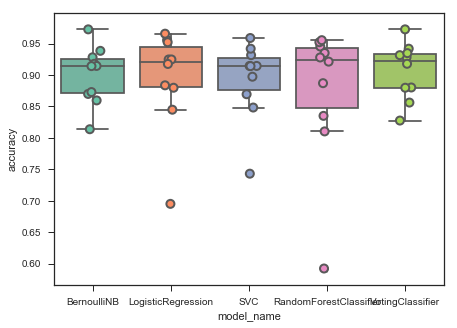

In [50]:
CV = 10
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_train, y_train_2, scoring='accuracy', cv=CV) 
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
        cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])


sns.boxplot(x='model_name', y='accuracy', data=cv_df,palette="Set2", saturation=0.7)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=8, jitter=True, edgecolor="gray", linewidth=2,palette="Set2")
plt.show()

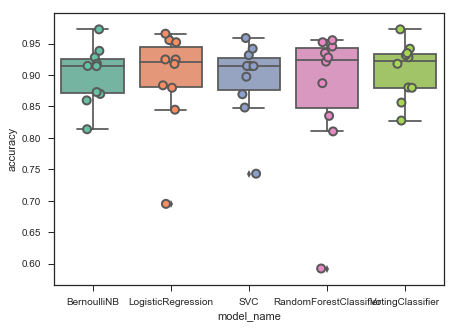

In [51]:
sns.boxplot(x='model_name', y='accuracy', data=cv_df,palette="Set2", saturation=0.7)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=8, jitter=True, edgecolor="gray", linewidth=2,palette="Set2")
plt.show()

In [52]:
NB_2_model = NB_2.fit(X_train, y_train_2)
y_pred_NB_2 = NB_2_model.predict(X_test)
scores_NB_2 = cross_val_score(NB_2, X_train, y_train_2, cv=10)
acc_NB_2 = sklearn.metrics.accuracy_score(y_test_2, y_pred_NB_2)

print('CV scores: {}'.format(scores_NB_2))
print('Average CVScore: {:0.3f} +/- {:0.3f}'.format(scores_NB_2.mean(), scores_NB_2.std()))
print('Accuracy on the test set: {}'.format(acc_NB_2))

CV scores: [ 0.92808219  0.86986301  0.91780822  0.91438356  0.85958904  0.93835616
  0.97250859  0.91408935  0.87285223  0.8137931 ]
Average CVScore: 0.900 +/- 0.044
Accuracy on the test set: 0.9136690647482014


In [53]:
LR_2_model = LR_2.fit(X_train, y_train_2)
y_pred_LR_2 = LR_2_model.predict(X_test)
scores_LR_2 = cross_val_score(LR_2, X_train, y_train_2, cv=10)
acc_LR_2 = sklearn.metrics.accuracy_score(y_test_2, y_pred_LR_2)

print('CV scores: {}'.format(scores_LR_2))
print('Average CVScore: {:0.3f} +/- {:0.3f}'.format(scores_LR_2.mean(), scores_LR_2.std()))
print('Accuracy on the test set: {}'.format(acc_LR_2))

CV scores: [ 0.92465753  0.69520548  0.92465753  0.95547945  0.88356164  0.95205479
  0.96563574  0.91752577  0.87972509  0.84482759]
Average CVScore: 0.894 +/- 0.075
Accuracy on the test set: 0.9336530775379697


In [54]:
SVC_2_model = SVC_2.fit(X_train, y_train_2)
y_pred_SVC_2 = SVC_2_model.predict(X_test)
scores_SVC_2 = cross_val_score(SVC_2, X_train, y_train_2, cv=10)
acc_SVC_2 = sklearn.metrics.accuracy_score(y_test_2, y_pred_SVC_2)

print('CV scores: {}'.format(scores_SVC_2))
print('Average CVScore: {:0.3f} +/- {:0.3f}'.format(scores_SVC_2.mean(), scores_SVC_2.std()))
print('Accuracy on the test set: {}'.format(acc_SVC_2))

CV scores: [ 0.91438356  0.74315068  0.91438356  0.93150685  0.89726027  0.94178082
  0.95876289  0.91408935  0.86941581  0.84827586]
Average CVScore: 0.893 +/- 0.059
Accuracy on the test set: 0.9224620303756994


In [55]:
RF_2_model = RF_2.fit(X_train, y_train_2)
y_pred_RF_2 = RF_2_model.predict(X_test)
scores_RF_2 = cross_val_score(RF_2, X_train, y_train_2, cv=10)
acc_RF_2 = sklearn.metrics.accuracy_score(y_test_2, y_pred_RF_2)

print('CV scores: {}'.format(scores_RF_2))
print('Average CVScore: {:0.3f} +/- {:0.3f}'.format(scores_RF_2.mean(), scores_RF_2.std()))
print('Accuracy on the test set: {}'.format(acc_RF_2))

CV scores: [ 0.92123288  0.59246575  0.8869863   0.94520548  0.93493151  0.95205479
  0.95532646  0.92783505  0.83505155  0.81034483]
Average CVScore: 0.876 +/- 0.106
Accuracy on the test set: 0.929656274980016


**Voting classifier:**

In [56]:
voting_2 = VotingClassifier(estimators=[('lr', LR_2), ('nb', NB_2), ('svc', SVC_2), ('rf', RF_2)], voting='soft', 
                          weights=[1,3,1,1], flatten_transform=True)
voting_model_2 = voting_2.fit(X_train, y_train_2)
y_pred_voting_2 = voting_2.predict(X_test)
scores_voting_2 = cross_val_score(voting_2, X_train, y_train_2, cv=10)
acc_voting_2 = sklearn.metrics.accuracy_score(y_test_2, y_pred_voting_2)

print('CV scores: {}'.format(scores_voting_2))
print('Average CVScore: {:0.3f} +/- {:0.3f}'.format(scores_voting_2.mean(), scores_voting_2.std()))
print('Accuracy on the test set: {}'.format(acc_voting_2))

CV scores: [ 0.92808219  0.85616438  0.91780822  0.93150685  0.88013699  0.94178082
  0.97250859  0.9347079   0.87972509  0.82758621]
Average CVScore: 0.907 +/- 0.042
Accuracy on the test set: 0.9232613908872902


**Performance metrics:**

In [57]:
print(metrics.classification_report(y_test_2, y_pred_voting_2, target_names = ['other', 'FL+DR+SF']))

             precision    recall  f1-score   support

      other       0.95      0.95      0.95       953
   FL+DR+SF       0.83      0.85      0.84       298

avg / total       0.92      0.92      0.92      1251



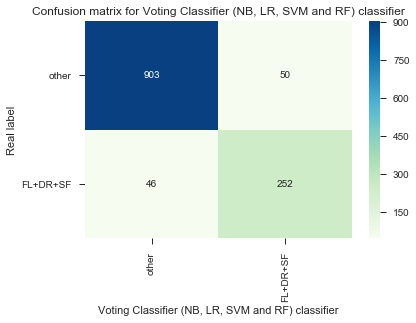

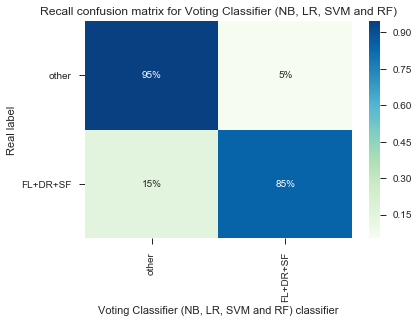

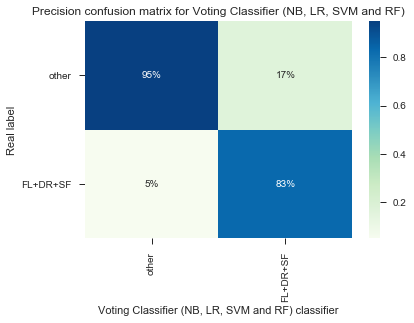

In [58]:
plot_confusion(y_test_2, y_pred_voting_2, 2,'Voting Classifier (NB, LR, SVM and RF)', my_cmap)

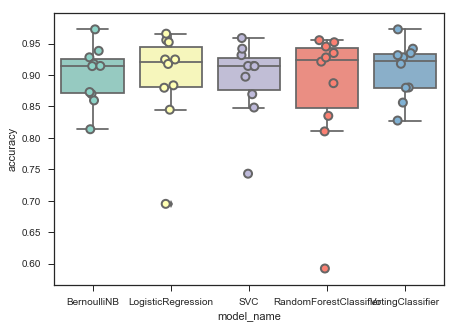

In [59]:
sns.boxplot(x='model_name', y='accuracy', data=cv_df, palette="Set3")
sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=8, jitter=True, edgecolor="gray", linewidth=2, palette="Set3")
plt.show()

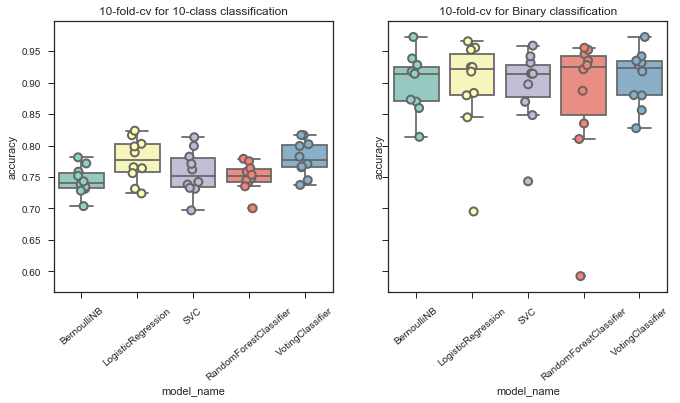

In [61]:
plt.rcParams['figure.figsize'] = (11, 5)
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
sns.boxplot(x='model_name', y='accuracy', data=cv_df_10, ax=ax1, palette="Set3")
sns.stripplot(x='model_name', y='accuracy', data=cv_df_10, size=8, jitter=True, edgecolor="gray", linewidth=2, ax=ax1, palette="Set3")
ax1.set_title('10-fold-cv for 10-class classification')
sns.boxplot(x='model_name', y='accuracy', data=cv_df, ax=ax2, palette="Set3")
sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=8, jitter=True, edgecolor="gray", linewidth=2, ax=ax2, palette="Set3")
ax2.set_title('10-fold-cv for Binary classification')
for ax in f.axes:
    plt.sca(ax)
    plt.xticks(rotation=40)
plt.show()

### Performance selecting only "Falhas Graves"

In [92]:
y_test_grave = test[test['Tipo_constatacao']=='Falha Grave']['Class_2'].values

test_min_feat = test[test['Tipo_constatacao']=='Falha Grave'][list_min+list_type].values
test_word_feat = design_matrix(rank_features, test[test['Tipo_constatacao']=='Falha Grave']['features'])
X_test_grave = scipy.sparse.hstack((test_min_feat, test_word_feat))

In [93]:
y_pred_voting_grave = voting_2.predict(X_test_grave)
acc_voting_grave = sklearn.metrics.accuracy_score(y_test_grave, y_pred_voting_grave)
acc_voting_grave

0.84530386740331487

In [106]:
confusion_matrix(y_test_grave, y_pred_voting_grave)

array([[83, 11],
       [17, 70]], dtype=int64)

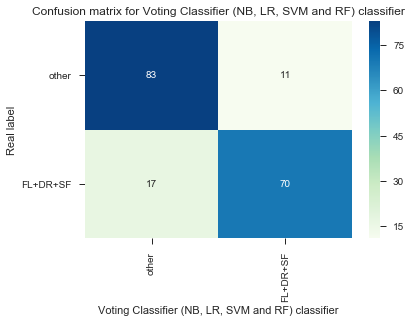

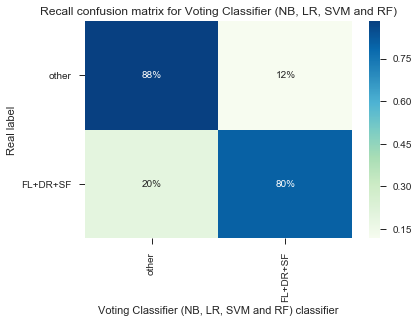

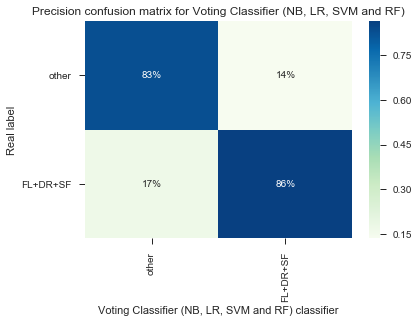

In [94]:
plot_confusion(y_test_grave, y_pred_voting_grave, 2,'Voting Classifier (NB, LR, SVM and RF)', my_cmap)

### Performance for municipality

In [174]:
z = supervised[supervised['Orgao_Sup_cod']=='EDUC'].reset_index(drop=True)
z = z[['Id_Mun_Sort', 'Falha Grave', 'Class_2']].groupby(by='Id_Mun_Sort').sum().reset_index()
z['Ind_Corrup'] = z['Falha Grave']*z['Class_2']
z['Ind_Corrup_test'] = np.where(z['Ind_Corrup']==0,0,1)
z['Ind_Corrup_test'].describe()

count    684.000000
mean       0.171053
std        0.376831
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: Ind_Corrup_test, dtype: float64

In [159]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(train, y_train)
for train_index, test_index in skf.split(train, y_train):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [ 105  106  107 ..., 2912 2913 2914] TEST: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153
 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171
 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 191 192
 193 194 195 196 197 198 199 201 202 203 204 205 206 207 208 209 210 211
 212 213 214 215 216 217 218 219 293 294 295 296 297 298 299 300 301 302
 303 304 305 306 307 308 309 310 311 312 403 404 405 406 407 408 409 410
 

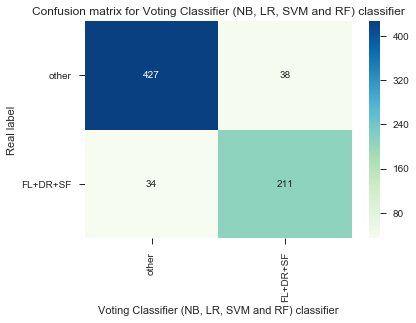

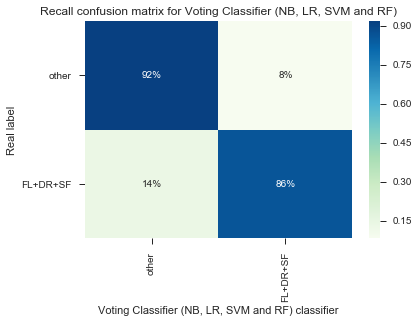

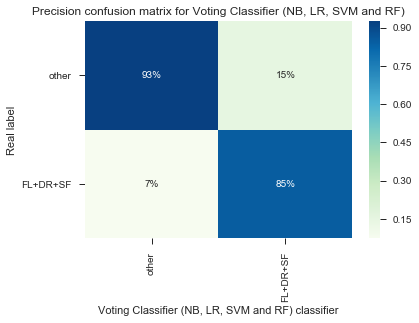

In [151]:
y_id = test['Id_Mun_Sort'].values
y_orgao = test['Orgao_Sup_cod'].values
y_test_2
y_pred_voting_2
groupby_mun = pd.DataFrame(
    {'id_mun': y_id,
     'orgao_sup': y_orgao,
     'test': y_test_2,
     'pred': y_pred_voting_2})
groupby_total = groupby_mun.groupby(by='id_mun').max().reset_index()
plot_confusion(groupby_total.test.values, groupby_total.pred.values, 2,'Voting Classifier (NB, LR, SVM and RF)', my_cmap)

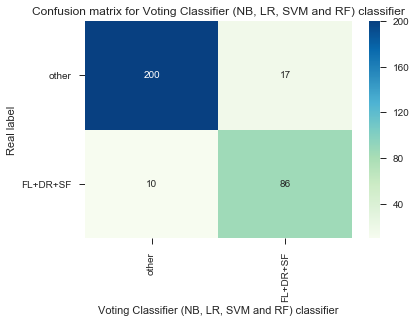

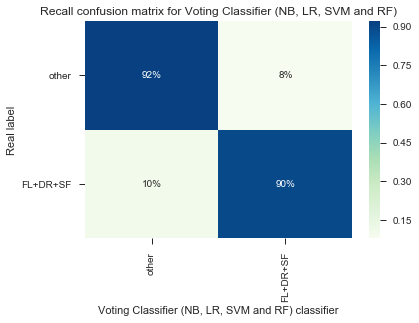

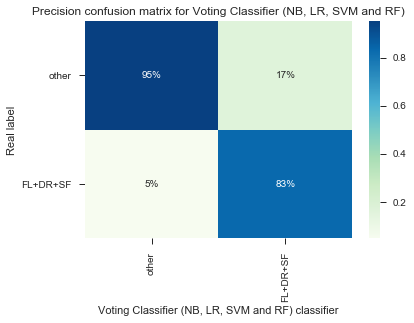

In [152]:
groupby_educ = groupby_mun[(groupby_mun['orgao_sup']=='EDUC')].groupby(by='id_mun').max().reset_index()
plot_confusion(groupby_educ.test.values, groupby_educ.pred.values, 2,'Voting Classifier (NB, LR, SVM and RF)', my_cmap)

# Classifying the entire dataset

In [98]:
data_save = data.copy()
data_min_feat = data_save[list_min+list_type].values
data_word_feat = design_matrix(rank_features, data_save['features'])
X_data = scipy.sparse.hstack((data_min_feat, data_word_feat))

In [99]:
data_save['NB_2'] = NB_2_model.predict(X_data)
data_save['LR_2'] = LR_2_model.predict(X_data)
data_save['SVC_2'] = SVC_2_model.predict(X_data)
data_save['RF_2'] = RF_2_model.predict(X_data)
data_save['voting_2'] = voting_model_2.predict(X_data)

In [100]:
data_save['NB_10'] = NB_10_model.predict(X_data)
data_save['LR_10'] = LR_10_model.predict(X_data)
data_save['SVC_10'] = SVC_10_model.predict(X_data)
data_save['RF_10'] = RF_10_model.predict(X_data)
data_save['voting_10'] = voting_model.predict(X_data)

In [101]:
relevant_cols = ['Id_Irreg', 'Id_Mun_Sort', 'Municipio', 'UF', 'Ano_Sorteio','descricao_sumaria', 'features', 
                 'Orgao_Sup_cod', 'Tipo_constatacao', 'Ind_class', 'Class_10', 'Class_2', 
                 'NB_2', 'LR_2', 'SVC_2', 'RF_2', 'voting_2',
                 'NB_10', 'LR_10', 'SVC_10', 'RF_10', 'voting_10']

In [102]:
data_save = data_save[relevant_cols]
data_save.head()

,Id_Irreg,Id_Mun_Sort,Municipio,UF,Ano_Sorteio,descricao_sumaria,features,Orgao_Sup_cod,Tipo_constatacao,Ind_class,...,NB_2,LR_2,SVC_2,RF_2,voting_2,NB_10,LR_10,SVC_10,RF_10,voting_10
0,Afogados da Ingazeira_040_1,Afogados da Ingazeira_040,Afogados da Ingazeira,PE,2015,Contrapartida municipal na Assistência Farmacê...,"[contrapartida, municip, assistência, farmacêu...",SAU,Falha Formal,0,...,0.0,0.0,0.0,0.0,0.0,5.0,5.0,4.0,5.0,5.0
1,Afogados da Ingazeira_040_2,Afogados da Ingazeira_040,Afogados da Ingazeira,PE,2015,Falta de atestado de conferência e recebimento...,"[falta, atestado, conferência, recebimento, me...",SAU,Falha Formal,0,...,0.0,0.0,0.0,0.0,0.0,6.0,6.0,6.0,6.0,6.0
2,Afogados da Ingazeira_040_3,Afogados da Ingazeira_040,Afogados da Ingazeira,PE,2015,Ineficiência do controle de estoque de medicam...,"[ineficiência, control, estoqu, medicamento, u...",SAU,Falha Média,0,...,0.0,0.0,0.0,0.0,0.0,6.0,6.0,6.0,6.0,6.0
3,Afogados da Ingazeira_040_4,Afogados da Ingazeira_040,Afogados da Ingazeira,PE,2015,Ineficiência do controle de estoque de medicam...,"[ineficiência, control, estoqu, medicamento, a...",SAU,Falha Média,0,...,0.0,0.0,0.0,0.0,0.0,6.0,6.0,6.0,6.0,6.0
4,Afogados da Ingazeira_040_5,Afogados da Ingazeira_040,Afogados da Ingazeira,PE,2015,Previsões editalícias restritivas ao caráter c...,"[previsõ, editalícia, restritiva, caráter, com...",SAU,Falha Média,0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [103]:
data_save.to_excel('CGU_data_Class_5.xlsx')

In [109]:
len(train['Municipio'].unique())

962